![Alt text](new.png)

# Calculate reference stress for each temperature at each strain rate

For each condition, calculate take the stress where strain is smaller than 0.08 and divide it by the reference stress at 298.15K

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from itertools import product  # Import product for grid search
from matplotlib.backends.backend_pdf import PdfPages

# Strain-rate dependent function fit

In [31]:
# Define the strain-rate dependency function
def strain_rate_dependent_stress(sr, C1, C2):
    return C1 * np.log(sr) + C2

def fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns):
    """
    Fits strain rate dependency for each row in a dataset and exports results.
    
    Parameters:
    - temperature_file (str): Path to the CSV file containing the data for a specific temperature.
    - strain_rates (list of float): List of strain rate values corresponding to columns in the dataset.
    - strain_rate_columns (list of str): List of column names in the data corresponding to strain rates.
    
    Output:
    - CSV file with columns: PEEQ, C1, C2, R_squared for each row in the dataset.
    """
    # Load the temperature-specific file
    data = pd.read_csv(f"../{temperature_file}.csv")
    
    # Default rows to plot
    plot_indices = [2, 4, 10, 11, 14, 15, 20, 25, 30, 35, 40, 45, 50,65,105,115]
    
    # Define a scaling factor for better readability in the plot legend
    scale_factor = 1e6

    
    # List to store the results
    results = []


    # Loop through all rows in the dataset for strain-rate dependency fitting
    for i in range(len(data)):
        # Extract reference stress data from 'StrRt0.0001' for each row
        ref_stress_values = data['StrRt0.0001'].iloc[i]

        # Extract stress data for other strain rates
        stress_values = data.iloc[i][strain_rate_columns].values
        
        # Initial guess and bounds for C1 and C2
        initial_guess_sr = [50e-6, 1900e-6]  # Adjusted initial guesses
        
        # Perform the curve fitting
        try:
            params_sr, _ = curve_fit(
                lambda sr, C1, C2: strain_rate_dependent_stress(sr, C1, C2),
                strain_rates, stress_values, p0=initial_guess_sr, maxfev=10000000, method='dogbox'
            )
        except RuntimeError:
            print(f"Could not fit strain-rate dependency for row {i}")
            continue
        
        
        # Calculate residuals and R-squared
        stress_fit = strain_rate_dependent_stress(strain_rates, *params_sr)
        residuals = stress_values - stress_fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((stress_values - np.mean(stress_values))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Store results for exporting
        results.append({
            "PEEQ": data['strain'].iloc[i],
            "C1": params_sr[0],
            "C2": params_sr[1],
            "R_squared": r_squared
        })
        
        plt_strain_rates = np.linspace(min(strain_rates), max(strain_rates), 1000)
        plt_stress_fit = strain_rate_dependent_stress(plt_strain_rates, *params_sr)

        # Plot only for specified rows with scaled C1 and C2 in legend
        plt.figure(figsize=(8, 6))  # Adjusted figure size
        if i in plot_indices:
            plt.scatter(strain_rates, stress_values, label='Data', color='blue', s=50)  # Scatter plot for data points
            plt.plot(
                plt_strain_rates, plt_stress_fit, 
                label=f'Fit (Strain={data["strain"].iloc[i]:.5f})', color='red', linewidth=2
            )  # Fit curve with labeled strain value
            
            # Customize axes and layout
            plt.xlabel('Strain Rate (s⁻¹)', fontsize=12)
            plt.ylabel('Normalized Stress', fontsize=12)
            plt.title('Strain-Rate Dependency of Stress', fontsize=14)
            plt.legend(fontsize=10)
            plt.tight_layout()
            plt.show()


    # Export results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"Parameters_{temperature_file}.csv", index=False)

# Parameter calibration for C1-C2

In [35]:
# Define the strain-rate dependency function
def strain_rate_dependent_stress(sr, C1, C2):
    return C1 * np.log(sr) + C2

def fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns):
    """
    Fits strain rate dependency for each row in a dataset and plots results.

    Parameters:
    - temperature_file (str): Path to the CSV file containing the data for a specific temperature.
    - strain_rates (list of float): List of strain rate values corresponding to columns in the dataset.
    - strain_rate_columns (list of str): List of column names in the data corresponding to strain rates.
    """
    # Load the temperature-specific file
    data = pd.read_csv(f"../{temperature_file}.csv")
    
    # Default rows to plot
    plot_indices = [2, 4, 10, 11, 14, 15, 20]

    # Loop through all rows in the dataset for strain-rate dependency fitting
    for i in range(len(data)):
        # Extract stress data for the specified strain rates
        stress_values = data.iloc[i][strain_rate_columns].values

        # Initial guess for C1 and C2
        initial_guess = [1.0, 1.0]
        
        # Perform curve fitting
        try:
            params, _ = curve_fit(
                strain_rate_dependent_stress,
                strain_rates, stress_values,
                p0=initial_guess, maxfev=10000
            )
        except RuntimeError:
            print(f"Could not fit strain-rate dependency for row {i}")
            continue
        
        # Generate fitted data for plotting
        plt_strain_rates = np.linspace(min(strain_rates), max(strain_rates), 1000)
        plt_stress_fit = strain_rate_dependent_stress(plt_strain_rates, *params)

        # Plot only for specified rows
        if i in plot_indices:
            plt.scatter(strain_rates, stress_values, label='Data', color='blue', s=50)
            plt.plot(
                plt_strain_rates, plt_stress_fit, 
                label=f'Fit (Strain={data["strain"].iloc[i]:.5f})', color='red'
            )
            plt.xlabel('Strain Rate (1/s)', fontsize=12)
            plt.ylabel('Normalized Stress', fontsize=12)
            plt.title('Strain-Rate Dependency of Stress', fontsize=14)
            plt.legend(fontsize=10)
            plt.tight_layout()
            plt.show()


In [ ]:
temperature_file = 'Tmp298.15_RD'
strain_rates = [0.0001, 0.001, 0.01, 0.1, 1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']
fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns)

temps = ['373.15', '473.15', '573.15', '673.15']
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']
for temp in temps:
    fit_strain_rate_dependency(f"Tmp{temp}_RD", strain_rates, strain_rate_columns)

## Validate the function accuracy

In [ ]:
def validate_student_function(temperature_file, strain_rates, strain_rate_columns):
    """Validates the original function using the fitted parameters and calculates R-value."""
    import matplotlib.pyplot as plt
    from cycler import cycler

    # Load the original data and the fitted parameters
    data = pd.read_csv(f"../{temperature_file}.csv")
    params_df = pd.read_csv(f"Parameters_{temperature_file}.csv")

    # Filter the parameters DataFrame for specific strain values (from the picture)
    target_strains = [0.00011, 0.0002, 0.0003, 0.0004, 0.0005]
    #target_strains = [0.01, 0.02, 0.03, 0.04, 0.05]
    params_df = params_df[params_df['PEEQ'].isin(target_strains)]

    # Define color scheme (matching the example plot)
    colors = ["blue", "red", "green", "purple", "orange"]

    plt.figure(figsize=(8, 6))
    plt.gca().set_prop_cycle(cycler('color', colors))

    for color, (_, row) in zip(colors, params_df.iterrows()):
        # Extract the parameters and stress data for comparison
        strain = row['PEEQ']
        C1, C2 = row[['C1', 'C2']]
        stress_values = data.iloc[int(row.name)][strain_rate_columns].values

        # Generate smooth strain rate values for plotting
        plt_sr = np.linspace(min(strain_rates), max(strain_rates), 100)
        plt_stress = strain_rate_dependent_stress(plt_sr, C1, C2)

        # Plot for visual validation
        plt.plot(strain_rates, stress_values, 'o', label=f'Data', color=color)
        plt.plot(plt_sr, plt_stress, '-', label=f'Fit (Strain={strain:.5f})', color=color)

    # Style adjustments for the plot
    plt.xlabel('Strain-rate (1/s)', fontsize=12)
    plt.ylabel('Normalized Stress', fontsize=12)
    #plt.ylim(0.75,2.2)
    plt.title(f'{temperature_file} low strain', fontsize=14)
    plt.legend(loc='best',fontsize=10)
    plt.show()

# Example usage
temperature_file = 'Tmp298.15_RD'
strain_rates = [0.0001, 0.001, 0.01, 0.1, 1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']
validate_student_function(temperature_file, strain_rates, strain_rate_columns)

temps = ['373.15', '473.15', '573.15', '673.15']
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']
for temp in temps:
    validate_student_function(f"Tmp{temp}_RD", strain_rates, strain_rate_columns)


## Check r_squared values

In [ ]:
def check_r_squared(temperature_files):
    """
    Checks R_squared values in the Parameters file for each temperature and reports the count
    and percentage of rows with R_squared below a specified threshold.
    
    Parameters:
    - temperature_files (list of str): List of temperature file names (without ".csv" extension).
    
    Output:
    - Prints the count and percentage of rows with R_squared < threshold for each temperature file.
    """
    threshold = 0.99 # adjust as needed

    for temp_file in temperature_files:
        # Load the data from the CSV file
        df = pd.read_csv(f"Parameters_{temp_file}.csv")
        
        # Count rows where R_squared is less than the threshold
        total_rows = len(df)
        count_high_r_squared = df[df['R_squared'] > threshold].shape[0]
        
        # Calculate the percentage of rows with low R_squared
        percentage_low_r_squared = (count_high_r_squared / total_rows) * 100 if total_rows > 0 else 0
        
        # Print results
        print(f"\nTemperature File: Parameters_{temp_file}.csv")
        if count_high_r_squared > 0:
            print(f"Number of rows with R_squared > {threshold}: {count_high_r_squared}")
            print(f"Percentage of rows with R_squared > {threshold}: {percentage_low_r_squared:.2f}%")
        else:
            print(f"All R_squared values are <= {threshold}.")

        r_min = min(df['R_squared'])
        r_max = max(df['R_squared'])
        r_a = sum(df['R_squared'])/total_rows
        print(f'Min = {r_min}. Max = {r_max}. Average = {r_a}')

# Usage
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD']  # List of temperature files to check
check_r_squared(temperature_files)


# Calibrate C1, C2 based on strain dependent

## Study relationship between C1, C2 vs strain

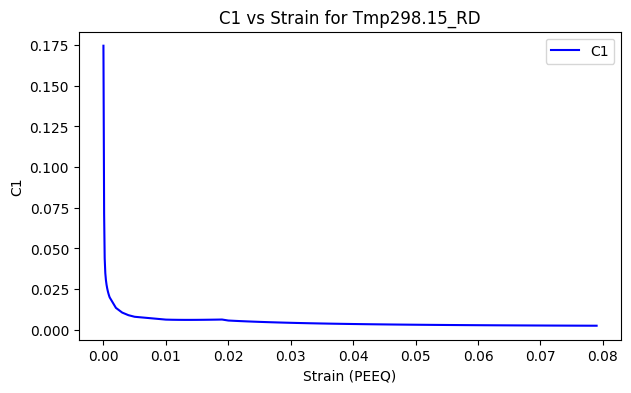

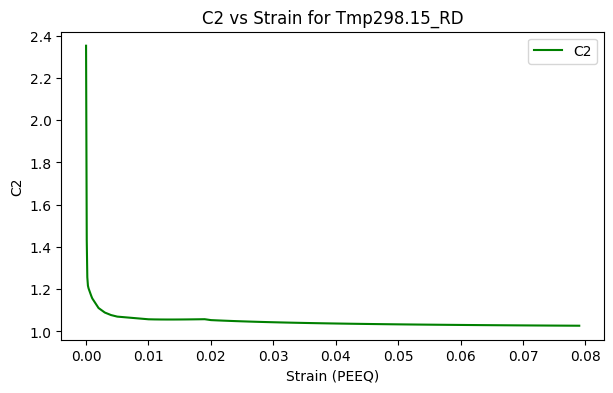

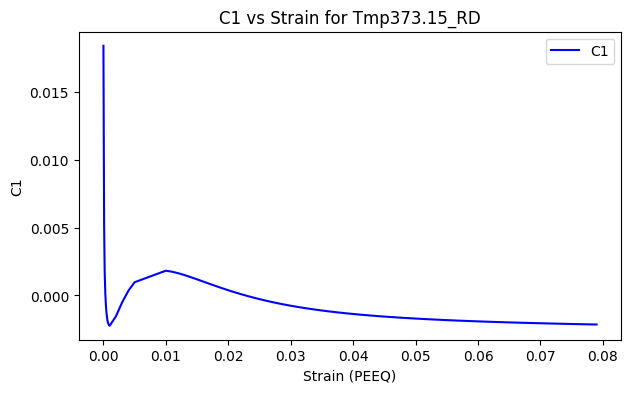

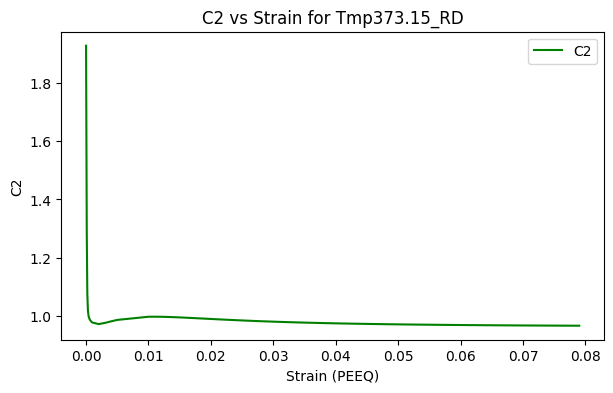

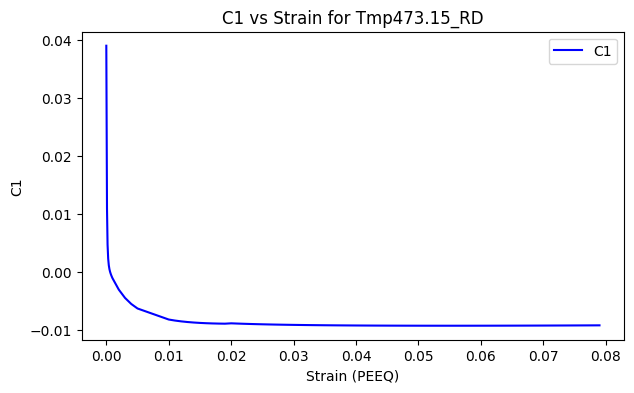

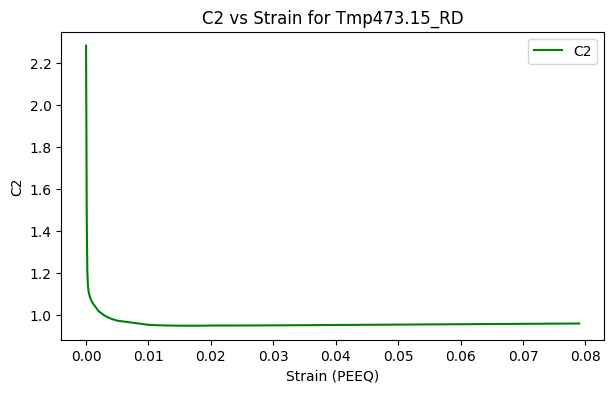

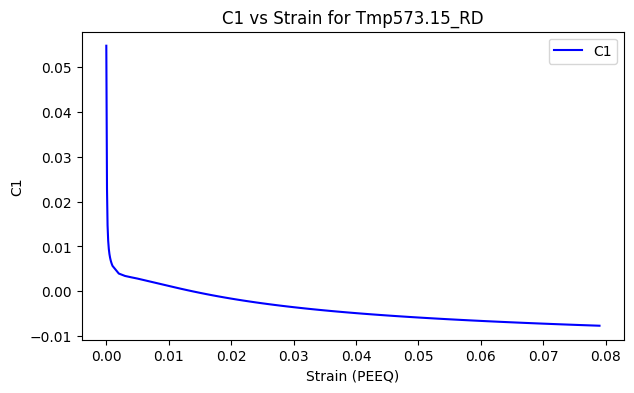

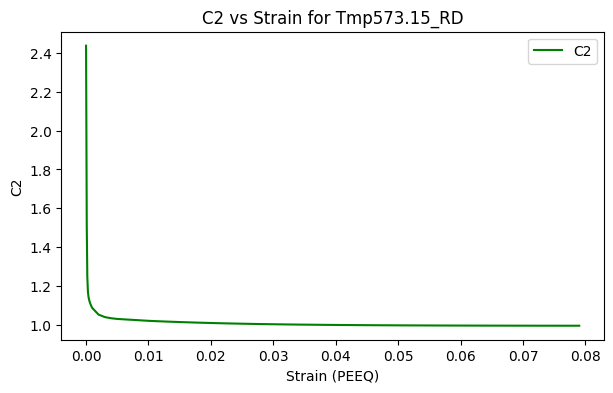

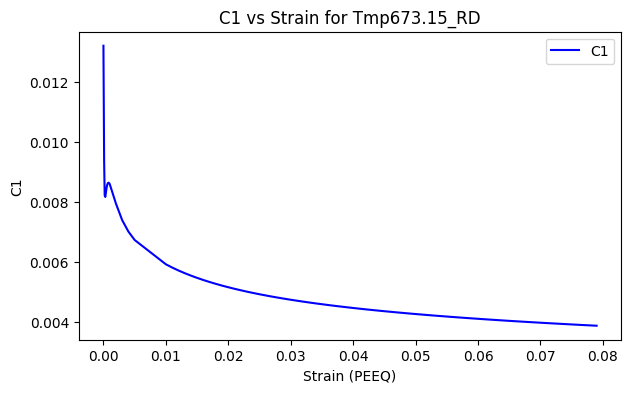

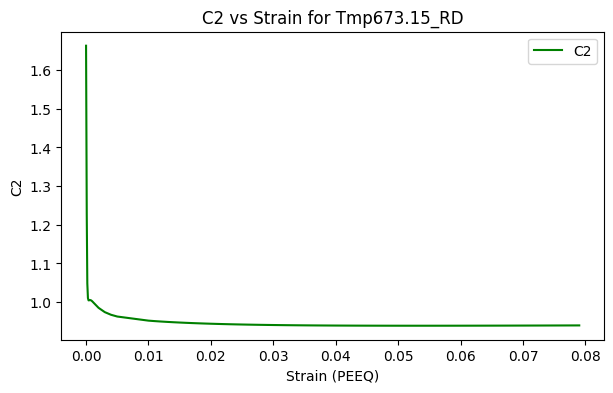

In [5]:
# List of temperature files to load
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD'] 

# Loop through each temperature file and plot C1 and C2 against strain (PEEQ)
for temp_file in temperature_files:
    # Load the data from the CSV file
    df = pd.read_csv(f"Parameters_{temp_file}.csv")
    
    # Plot C1 vs. strain with lines
    plt.figure(figsize=(7, 4))
    plt.plot(df['PEEQ'], df['C1'], color='blue', label='C1')  # Line plot with points
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C1')
    plt.title(f"C1 vs Strain for {temp_file}")
    plt.legend()
    plt.show()

    # Plot C2 vs. strain with lines
    plt.figure(figsize=(7, 4))
    plt.plot(df['PEEQ'], df['C2'], color='green', label='C2')  # Line plot with points
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C2')
    plt.title(f"C2 vs Strain for {temp_file}")
    plt.legend()
    plt.show()

## Calibrate strain dependent function for C1 and C2

In [6]:
def calibrate_strain_dependent(temp_file):
    data = pd.read_csv(f"Parameters_{temp_file}.csv")  # Replace with your actual file path
    strain = data['PEEQ']  # Strain values
    C1_values = data['C1']  # C1 values
    C2_values = data['C2']  # C2 values

    # Define the stretched exponential model
    def stretched_exponential(epsilon, a, b, c, d):
        return a * np.exp(-b * epsilon**c) + d

    # Initial guesses for C1
    initial_guess_C1 = [2.0, 10, 0.5, 0.9]


    # Fit the stretched exponential model to C1
    popt_C1, _ = curve_fit(stretched_exponential, strain, C1_values, p0=initial_guess_C1, maxfev=10000000)
    popt_C2, _ = curve_fit(stretched_exponential, strain, C2_values, p0=initial_guess_C1, maxfev=10000000)

    # Generate strain values for fitting curves
    strain_fit = np.linspace(min(strain), max(strain), 100)

    # Generate fitted values using the stretched exponential model
    C1_fit = stretched_exponential(strain_fit, *popt_C1)
    C2_fit = stretched_exponential(strain_fit, *popt_C2)

    # Calculate the fitted values at the original strain points for R^2 score calculation
    C1_fitted_values = stretched_exponential(strain, *popt_C1)
    C2_fitted_values = stretched_exponential(strain, *popt_C2)

    # Calculate R^2 scores
    r2_C1 = r2_score(C1_values, C1_fitted_values)
    r2_C2 = r2_score(C2_values, C2_fitted_values)

    fitted_df = pd.DataFrame({
        'strain': strain,
        'C1': C1_fitted_values,
        'C2': C2_fitted_values
    })
    fitted_df.to_csv(f"Fitted_Parameters_{temp_file}.csv", index=False)

    # Plot C1 vs Strain with stretched exponential fit
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C1_values, 'o', label='C1 Data')
    plt.plot(strain_fit, C1_fit, '-', label='C1 Fit (Stretched Exponential)')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C1')
    plt.legend()
    plt.title(f"C1 vs Strain with Stretched Exponential Fit {temp_file} (R^2: {r2_C1:.3f})")
    plt.show()

    # Plot C2 vs Strain with stretched exponential fit
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C2_values, 'o', label='C2 Data')
    plt.plot(strain_fit, C2_fit, '-', label='C2 Fit (Stretched Exponential)')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C2')
    plt.legend()
    plt.title(f"C2 vs Strain with Stretched Exponential Fit {temp_file} (R^2: {r2_C2:.3f})")
    plt.show()

    # Print the fitted parameters for reference
    print("Stretched Exponential Fit Parameters for C1:", popt_C1)
    print("Stretched Exponential Fit Parameters for C1:", popt_C2)


In [ ]:
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD'] 

# Loop through each temperature file and plot C1 and C2 against strain (PEEQ)
for temp_file in temperature_files:
    calibrate_strain_dependent(temp_file)

# Validate the student funcion with calibrated parameters

In [21]:
def validate_original_function(temperature_file, strain_rates, strain_rate_columns):
    """Validates the original function using the fitted parameters and calculates R-value."""
    # Load the original data and the fitted parameters
    data = pd.read_csv(f"../{temperature_file}.csv")
    params_df = pd.read_csv(f"Fitted_Parameters_{temperature_file}.csv")
    r_values_list = []  # List to store R-values for each row

    # Create a PDF file to save the plots
    pdf_filename = f"Validation_Plots_{temperature_file}.pdf"
    with PdfPages(pdf_filename) as pdf:
        for i in range(len(data)):
            # Extract the parameters and stress data for comparison
            strain = params_df.iloc[i]['strain']
            C1, C2= params_df.iloc[i][['C1', 'C2']]
            stress_values = data.iloc[i][strain_rate_columns].values

            # Generate smooth strain rate values for plotting
            plt_sr = np.linspace(min(strain_rates), max(strain_rates), 100)
            plt_stress = strain_rate_dependent_stress(plt_sr, C1, C2)

            # Compute stress from the original function at discrete strain rates
            fitted_stress = strain_rate_dependent_stress(np.array(strain_rates), C1, C2)

            # Calculate the R-value (correlation coefficient)
            residuals = stress_values - fitted_stress
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((stress_values - np.mean(stress_values))**2)
            r_value = 1 - (ss_res / ss_tot)
            r_values_list.append({'Row': strain, 'R_squared': r_value})

            # Plot only a limited number of rows for visual validation
            plt.figure(figsize=(10, 5))
            plt.plot(strain_rates, stress_values, 'o', label='Original Data')
            plt.plot(plt_sr, plt_stress, '-', label='Fitted Model')
            plt.xlabel('Strain Rate')
            plt.ylabel('Stress')
            plt.title(f'Validation for Row {i} {temperature_file} (R-value = {r_value:.3f})')
            plt.legend()
            plt.grid()
            pdf.savefig()  # Save the current figure to the PDF
            plt.close()  # Close the figure to avoid displaying it multiple times

    # Save R-values to CSV
    r_values_df = pd.DataFrame(r_values_list)
    r_values_df.to_csv(f"R_values_{temperature_file}.csv", index=False)
    print(f"Plots saved to {pdf_filename} and R-values saved to CSV.")

# Example usage
temperature_file = 'Tmp298.15_RD'
strain_rates = [0.0001, 0.001, 0.01, 0.1, 1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']
validate_original_function(temperature_file, strain_rates, strain_rate_columns)

temps = ['373.15', '473.15', '573.15', '673.15']
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']
for temp in temps:
    validate_original_function(f"Tmp{temp}_RD", strain_rates, strain_rate_columns)

Plots saved to Validation_Plots_Tmp298.15_RD.pdf and R-values saved to CSV.
Plots saved to Validation_Plots_Tmp373.15_RD.pdf and R-values saved to CSV.
Plots saved to Validation_Plots_Tmp473.15_RD.pdf and R-values saved to CSV.
Plots saved to Validation_Plots_Tmp573.15_RD.pdf and R-values saved to CSV.
Plots saved to Validation_Plots_Tmp673.15_RD.pdf and R-values saved to CSV.


## Check r_squared values

In [8]:
def check_r_squared(temperature_files):
    threshold = 0.99 # adjust as needed

    for temp_file in temperature_files:
        # Load the data from the CSV file
        df = pd.read_csv(f"R_values_{temp_file}.csv")
        
        # Count rows where R_squared is less than the threshold
        total_rows = len(df)
        count_high_r_squared = df[df['R_squared'] > threshold].shape[0]
        
        # Calculate the percentage of rows with low R_squared
        percentage_low_r_squared = (count_high_r_squared / total_rows) * 100 if total_rows > 0 else 0
        
        # Print results
        print(f"\nTemperature File: Parameters_{temp_file}.csv")
        if count_high_r_squared > 0:
            print(f"Number of rows with R_squared > {threshold}: {count_high_r_squared}")
            print(f"Percentage of rows with R_squared > {threshold}: {percentage_low_r_squared:.2f}%")
        else:
            print(f"All R_squared values are <= {threshold}.")

        r_min = min(df['R_squared'])
        r_max = max(df['R_squared'])
        r_a = sum(df['R_squared'])/total_rows
        print(f'Min = {r_min}. Max = {r_max}. Average = {r_a}')

# Usage
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD']  # List of temperature files to check
check_r_squared(temperature_files)



Temperature File: Parameters_Tmp298.15_RD.csv
All R_squared values are <= 0.99.
Min = 0.3987523820796871. Max = 0.9167577153001728. Average = 0.7521417123648574

Temperature File: Parameters_Tmp373.15_RD.csv
All R_squared values are <= 0.99.
Min = -2.771188945734503. Max = 0.2930973035188861. Average = -0.5180351249026433

Temperature File: Parameters_Tmp473.15_RD.csv
All R_squared values are <= 0.99.
Min = -2.9701712939839053. Max = 0.8071176688651828. Average = 0.46304097102380914

Temperature File: Parameters_Tmp573.15_RD.csv
All R_squared values are <= 0.99.
Min = -29.832695785463645. Max = 0.8727867586996898. Average = -1.4739617746232117

Temperature File: Parameters_Tmp673.15_RD.csv
All R_squared values are <= 0.99.
Min = -0.8224514266831804. Max = 0.9599638981465872. Average = 0.7091572257709843
